# <b>Were RNNs All We Needed?</b>
[https://arxiv.org/pdf/2410.01201](https://arxiv.org/pdf/2410.01201)

Traditional RNN architectures like GRUs and LSTMs have been widely used for sequence modeling due to their ability to handle temporal dependencies. However, these models come with significant drawbacks. Training requires **backpropagation through time (BPTT)**, which is computationally intensive and limits parallelization. Additionally, they are prone to **vanishing** and **exploding gradient** issues, especially when processing long sequences.

The **minGRU** addresses these limitations. It removes the need for BPTT by eliminating hidden state dependencies in its gates, enabling **parallelized training**. This leads to faster training times and improved scalability for longer sequences. 


In [1]:
%load_ext autoreload
%autoreload 2

from typing import Optional

import torch
from torch import nn
from torch import Tensor as T
from torch.nn import functional as F
from torch.profiler import profile, ProfilerActivity

## First, the normal GRU
All 3 gates and their 6 corresponding weights matrices and bias terms can be processed at the same time via chunking.
This is not only more efficient, but also equivalent to the way a GRU is usually defined.

This implementation is equivalent to the PyTorch GRU except for bidirectionality, which is omitted for aesthetic reasons.

In [2]:
class GRUCell(nn.Module):
    def __init__(self, input_size:int, hidden_size:int):
        super(GRUCell, self).__init__()
        # here we perform all the operations on the input in one go, more efficient
        self.W_i = nn.Parameter(torch.empty(input_size, hidden_size * 3))
        self.b_i = nn.Parameter(torch.empty(hidden_size * 3))
        self.W_h = nn.Parameter(torch.empty(hidden_size, hidden_size * 3))
        self.b_h = nn.Parameter(torch.empty(hidden_size * 3))

        nn.init.xavier_normal_(self.W_i), nn.init.zeros_(self.b_i)
        nn.init.xavier_normal_(self.W_h), nn.init.zeros_(self.b_h)

    def forward(self, x:T, h:T)->T:
        i_r, i_z, i_n = (x @ self.W_i + self.b_i).chunk(3, dim=-1)
        h_r, h_z, h_n = (h @ self.W_h + self.b_h).chunk(3, dim=-1)
        # reset gate, update gate
        r, z = torch.sigmoid(i_r + h_r), torch.sigmoid(i_z + h_z)
        # candidate hidden state
        h_tilde = torch.tanh(i_n + r * h_n)
        # update hidden state
        return z * h + (1 - z) * h_tilde
    
# Equivalent to the PyTorch GRU except for bidirectionality
class GRU(nn.Module):
    def __init__(self, input_size:int, hidden_size:int, n_layers:int=1):
        super(GRU, self).__init__()
        self.input_size, self.hidden_size, self.n_layers = input_size, hidden_size, n_layers

        self.gru_cells = nn.ModuleList([
            GRUCell(input_size if i==0 else hidden_size, hidden_size) for i in range(n_layers)
        ])

    def forward(self, x:T, h_0:Optional[T]=None)->tuple[T, T]:
        B, L, _ = x.shape

        if h_0 is None: h_0 = torch.zeros(self.n_layers, B, self.hidden_size, device=x.device)

        h_t = [h for h in h_0] # avoid in-place operations

        output = []
        for t in range(L):
            for i, cell in enumerate(self.gru_cells):
                h_t[i] = cell(x[:, t] if i==0 else h_t[i - 1], h_t[i]) # stacked layers receive the output of the previous layer
                
            output.append(h_t[-1])

        return torch.stack(output, dim=1), torch.stack(h_t, dim=0)
    
gru = GRU(input_size=10, hidden_size=20, n_layers=1)
x, h = gru(torch.randn(5, 3, 10))
x.shape, h.shape

(torch.Size([5, 3, 20]), torch.Size([1, 5, 20]))

We can assure ourselves that our implementation is correct by comparing it to PyTorch's GRU.

First we copy over the weights and then we see whether both the forward pass and the backward pass are the same.

In [3]:
import numpy as np

def copy_weights_to_torch_rnn(gru, torch_gru):
    for i in range(gru.n_layers):
        getattr(torch_gru, 'weight_ih_l' + str(i)).data.copy_(gru.gru_cells[i].W_i.data.T)
        getattr(torch_gru, 'weight_hh_l' + str(i)).data.copy_(gru.gru_cells[i].W_h.data.T)
        getattr(torch_gru, 'bias_ih_l' + str(i)).data.copy_(gru.gru_cells[i].b_i.data)
        getattr(torch_gru, 'bias_hh_l' + str(i)).data.copy_(gru.gru_cells[i].b_h.data)

torch_gru = nn.GRU(10, 20, 1)
copy_weights_to_torch_rnn(gru, torch_gru)

x = torch.randn(5, 3, 10)
h0 = torch.randn(1, 5, 20)  # normally zero, but for testing purposes
out, h = gru(x, h0)
out_torch, h_torch = torch_gru(x.transpose(0, 1), h0)  # PyTorch implementation expects (seq_len, batch, input_size)

np.testing.assert_allclose(out.detach().numpy(), out_torch.detach().numpy().transpose(1, 0, 2), atol=1e-3)
np.testing.assert_allclose(h.detach().numpy(), h_torch.detach().numpy(), atol=1e-3)

out.mean().backward()
out_torch.mean().backward()

np.testing.assert_allclose(gru.gru_cells[0].W_i.grad.data.cpu().detach().numpy().T, torch_gru.weight_ih_l0.grad.data.cpu().detach().numpy(), atol=1e-3)
np.testing.assert_allclose(gru.gru_cells[0].W_h.grad.data.cpu().detach().numpy().T, torch_gru.weight_hh_l0.grad.data.cpu().detach().numpy(), atol=1e-3)
np.testing.assert_allclose(gru.gru_cells[0].b_i.grad.data.cpu().detach().numpy(), torch_gru.bias_ih_l0.grad.data.cpu().detach().numpy(), atol=1e-3)
np.testing.assert_allclose(gru.gru_cells[0].b_h.grad.data.cpu().detach().numpy(), torch_gru.bias_hh_l0.grad.data.cpu().detach().numpy(), atol=1e-3)


Here we see the total CPU wall time of the model along with useful metrics like how often certain kernels are executed and how much memory is being used.

In [6]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True) as prof:
    output = gru(torch.randn(32, 128, 10))

print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
              aten::add        19.66%       7.313ms        19.66%       7.313ms       9.522us       3.12 Mb       3.12 Mb           768  
           aten::matmul         1.74%     648.448us        26.09%       9.705ms      37.911us       1.88 Mb           0 b           256  
               aten::mm        24.01%       8.933ms        24.35%       9.057ms      35.378us       1.88 Mb       1.88 Mb           256  
              aten::mul         8.28%       3.082ms         8.28%       3.082ms       8.025us     960.00 Kb     960.00 Kb           384  
          aten::sigmoid         5.

## Then, the minGRU

The minGRU has two modes of operation: parallel and sequential.

### Parallel mode
Called by the default PyTorch `forward` method. Processes the entire sequence at once via the parallel scan operation.

### Sequential mode
Reintroduces the sequential nature of the GRU to attain O(1) inference time.

In [7]:
# Parallel scan for log-space computation, enables parallelization of the sequential operations
def paralell_scan(log_coefs:T, log_values:T)->T:
    a_star = F.pad(torch.cumsum(log_coefs, dim=1), (0, 0, 1, 0))
    log_h0_plus_b_star = torch.logcumsumexp(log_values - a_star, dim=1)
    log_h = a_star + log_h0_plus_b_star
    return torch.exp(log_h)[:, 1:]

# Ensures the candidate hidden state is positive and stabilizes range
def stabilize_candidate(x):
    return torch.where(x >= 0, x + 0.5, torch.sigmoid(x))

# Logarithmic transformation for positive candidate hidden state with stability in log-space
def stabilize_log_candidate(x):
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

class minGRUCell(nn.Module):
    def __init__(self, input_size:int, hidden_size:int):
        super(minGRUCell, self).__init__()
        self.hidden_size = hidden_size

        self.W = nn.Parameter(torch.empty(input_size, hidden_size * 2))
        self.b = nn.Parameter(torch.empty(hidden_size * 2))

        nn.init.xavier_normal_(self.W), nn.init.zeros_(self.b)

    def forward(self, x:T)->T:  # the paralell mode
        B, L, D_in = x.shape
        k, h_tilde = (x @ self.W + self.b).chunk(2, dim=-1)
        log_z = - F.softplus(-k)
        log_coefs = -F.softplus(k)
        log_h0 = stabilize_log_candidate(torch.zeros(B, 1, self.hidden_size, device=x.device))  # 1 since h_0 is only the initial point in the sequence
        log_h_tilde = stabilize_log_candidate(h_tilde)
        return paralell_scan(log_coefs, torch.cat([log_h0, log_z + log_h_tilde], dim=1))

    @torch.no_grad()
    def inference(self, x:T, h:T)->T:  # the sequential mode
        z, h_tilde = (x @ self.W + self.b).chunk(2, dim=-1)
        z = torch.sigmoid(z)
        h_tilde = stabilize_candidate(h_tilde)
        return (1 - z) * h + z * h_tilde


class minGRU(nn.Module):
    def __init__(self, input_size:int, hidden_size:int, n_layers:int=1):
        super(minGRU, self).__init__()
        self.input_size, self.hidden_size, self.n_layers = input_size, hidden_size, n_layers

        self.min_gru_cells = nn.ModuleList([
            minGRUCell(input_size if i==0 else hidden_size, hidden_size) for i in range(n_layers)
        ])

    def forward(self, x:T)->T:  # the parallel mode
        output = None
        for i, cell in enumerate(self.min_gru_cells):
            output = cell(x if i==0 else output)  # the first layer takes the input, the rest take the output of the previous layer
        return output
    
    @torch.no_grad()
    def inference(self, x:T, h_0:Optional[T]=None)->T:  # the sequential mode
        B, L, _ = x.shape

        if h_0 is None: h_0 = torch.zeros(self.n_layers, B, self.hidden_size, device=x.device)

        h_t = [h for h in h_0]

        output = []
        for t in range(L):
            for i, cell in enumerate(self.min_gru_cells):
                h_t[i] = cell.inference(x[:, t] if i==0 else output[i - 1], h_t[i])
            output.append(h_t[-1])

        return torch.stack(output, dim=1), torch.stack(h_t, dim=0)


mingru = minGRU(input_size=10, hidden_size=20, n_layers=1)
x = mingru(torch.randn(5, 3, 10))
x.shape

torch.Size([5, 3, 20])

If we compare this to the profile of the normal GRU, we see that the minGRU is much faster and uses less memory.

It is worthwhile to note the difference in the `# of Calls` column. This exemplifies the difference between the two modes of operation, not having to repeat operations for each time step.


In [8]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True) as prof:
    output = mingru(torch.randn(32, 128, 10))

print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                aten::add         7.59%     317.213us         8.10%     338.413us      67.683us       1.57 Mb       1.57 Mb             5  
                aten::neg         4.56%     190.426us         4.56%     190.426us      27.204us       1.57 Mb       1.57 Mb             7  
           aten::softplus        17.86%     746.175us        17.86%     746.175us     186.544us     962.50 Kb     962.50 Kb             4  
              aten::empty         0.90%      37.540us         0.90%      37.540us       6.257us     807.50 Kb     807.50 Kb             6  
             aten::m

If we compare the time it takes to perform a backward pass, we see that the minGRU is half an order of magnitude faster.

In [9]:
%timeit -n 10 -r 10 gru(torch.randn(32, 128, 10))[0].mean().backward()  # [0] since the original GRU's forward returns a tuple
%timeit -n 10 -r 10 mingru(torch.randn(32, 128, 10)).mean().backward()

68.5 ms ± 4.3 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
8.9 ms ± 402 μs per loop (mean ± std. dev. of 10 runs, 10 loops each)


## Now, in application

We will be training both models on a simple text generation task.

In [10]:
import re
from urllib import request

hamlet = request.urlopen("https://www.gutenberg.org/files/1524/1524-0.txt").read().decode('utf-8')
hamlet = re.sub('[\ufeff\r]', '', hamlet) # replace \ufeff\r with ''
hamlet = re.sub('[\n]', ' ', hamlet) # replace newline with space
example_start = hamlet.find("To be, or not to be,")
hamlet[example_start:example_start+100]

'To be, or not to be, that is the question: Whether ’tis nobler in the mind to suffer The slings and '

For brevity's sake, we will do character-level model without a **tokenizer**. A discussion on tokenization (in particular Byte-Pair Encoding) can be found in the [BPE notebook](bpe_tokenizer.ipynb) in this repository.

In [11]:
chr_to_ids = {c:i for i,c in enumerate(set(hamlet))}
ids_to_chr = {i:c for c,i in chr_to_ids.items()}

In [12]:
from torch.utils.data import DataLoader, TensorDataset

SEQ_LEN = 256
hamlet_tensor = torch.tensor([chr_to_ids[c] for c in hamlet], dtype=torch.long)
hamlet_tensor = hamlet_tensor.unfold(0, SEQ_LEN, SEQ_LEN)  # unfold into len(hamlet) // SEQ_LEN, SEQ_LEN tensor

dataset = TensorDataset(hamlet_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

The code below defines the training procedure for a single epoch of character-level language modeling

In [13]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import cycle

BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model:nn.Module, model_name:str, n_epochs:int=10):
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    losses = []

    n_steps = len(dataloader) * n_epochs
    cycle_dataloader = cycle(dataloader)  # make the dataloader loop

    model.train()
    for _ in tqdm(range(n_steps), desc=f"Training {model_name}"):
        batch = next(cycle_dataloader)[0].to(DEVICE)  # batch was a list of length 1 with the batch tensor

        output = model(batch[:, :-1])  # input is everything except the last character

        loss = criterion(output.view(-1, len(chr_to_ids)), batch[:, 1:].reshape(-1))  # target is everything except the first character

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return model, losses

Now we are ready to train the models. For the first test we will configure the models to have the same input / hidden sizes. This is not a fair comparison since minGRU has fewer parameters.

In [14]:
def count_parameters(model:nn.Module)->int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Training minGRU: 100%|██████████| 250/250 [00:02<00:00, 91.66it/s]


GRU has 1,044,443M parameters and minGRU has 190,427M parameters, or 5.48x more.


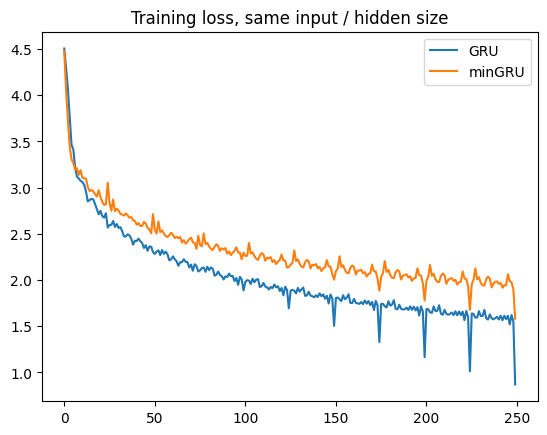

In [15]:
class SelectFirst(nn.Module):  # a nasty hack to circumvent the fact that GRU returns a tuple
    def forward(self, x): return x[0]

gru = nn.Sequential(
    nn.Embedding(len(chr_to_ids), 128),
    GRU(input_size=128, hidden_size=512, n_layers=1),
    SelectFirst(),
    nn.Linear(512, len(chr_to_ids))
)
mingru = nn.Sequential(
    nn.Embedding(len(chr_to_ids), 128),
    minGRU(input_size=128, hidden_size=512, n_layers=1),
    nn.Linear(512, len(chr_to_ids))
)

gru, gru_losses = train_model(gru, "GRU")
mingru, mingru_losses = train_model(mingru, "minGRU")

print(f"GRU has {count_parameters(gru):,}M parameters and minGRU has {count_parameters(mingru):,}M parameters, or {count_parameters(gru) / count_parameters(mingru):.2f}x more.")

plt.title("Training loss, same input / hidden size")
plt.plot(gru_losses, label='GRU')
plt.plot(mingru_losses, label='minGRU')
plt.legend()
plt.show()

In [16]:
gru = GRU(input_size=128, hidden_size=512, n_layers=1)
mingru = minGRU(input_size=512, hidden_size=1024, n_layers=1)  # fairer to align parameter counts without the language modeling head / tail

print(f"GRU has {count_parameters(gru):,} parameters and minGRU has {count_parameters(mingru):,} parameters, or {count_parameters(gru) / count_parameters(mingru):.2f}x more.")

GRU has 986,112 parameters and minGRU has 1,050,624 parameters, or 0.94x more.


GRU has 986,112M parameters and minGRU has 1,190,491M parameters, or 0.83x more.


Training minGRU: 100%|██████████| 250/250 [00:05<00:00, 48.82it/s]


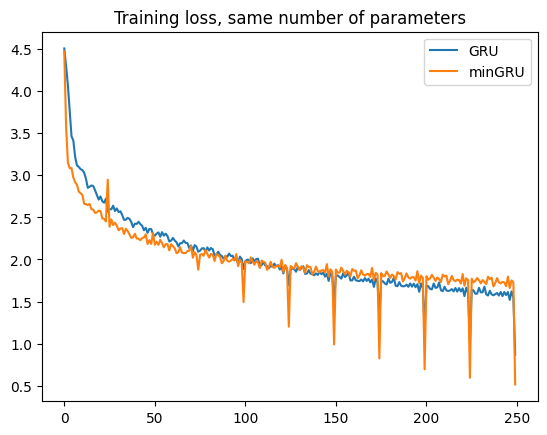

In [18]:
mingru_bigger = nn.Sequential(
    nn.Embedding(len(chr_to_ids), 512),
    minGRU(input_size=512, hidden_size=1024, n_layers=1),
    nn.Linear(1024, len(chr_to_ids))
)

print(f"GRU has {count_parameters(gru):,}M parameters and minGRU has {count_parameters(mingru_bigger):,}M parameters, or {count_parameters(gru) / count_parameters(mingru_bigger):.2f}x more.")

mingru_bigger, mingru_bigger_losses = train_model(mingru_bigger, "minGRU")

plt.title("Training loss, same number of parameters")
plt.plot(gru_losses, label='GRU')
plt.plot(mingru_bigger_losses, label='minGRU')
plt.legend()
plt.show()
